### Summarizing permutation test for mutation rate as function of CDR dist and local identity 

In [1]:
CDR_indel_results="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_short_indels/cdr_indel_per_chrom_results.csv"
CDR_SNV_results="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_SNVs/cdr_per_chrom_results.csv"
CDR_SV_results="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_svs/local_id_sv_per_chrom_results.csv"

local_id_indel_results="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_short_indels/local_id_indel_per_chrom_results.csv"
local_id_snv_results="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps/local_id_per_chrom_results.csv"
local_id_sv_results="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_svs/local_id_sv_per_chrom_results.csv"

CDR_indel_null="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_short_indels/cdr_indel_null_distribution_per_chr.csv"
CDR_SV_null="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_svs/local_id_sv_null_distribution_per_chr.csv"
CDR_SNV_null="/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_SNVs/cdr_null_distribution_per_chr.csv"

local_id_indel_null="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_short_indels/local_id_indel_null_distribution_per_chr.csv"
local_id_snv_null="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps/local_id_null_distribution_per_chr.csv"
local_id_sv_null="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_svs/local_id_sv_null_distribution_per_chr.csv"

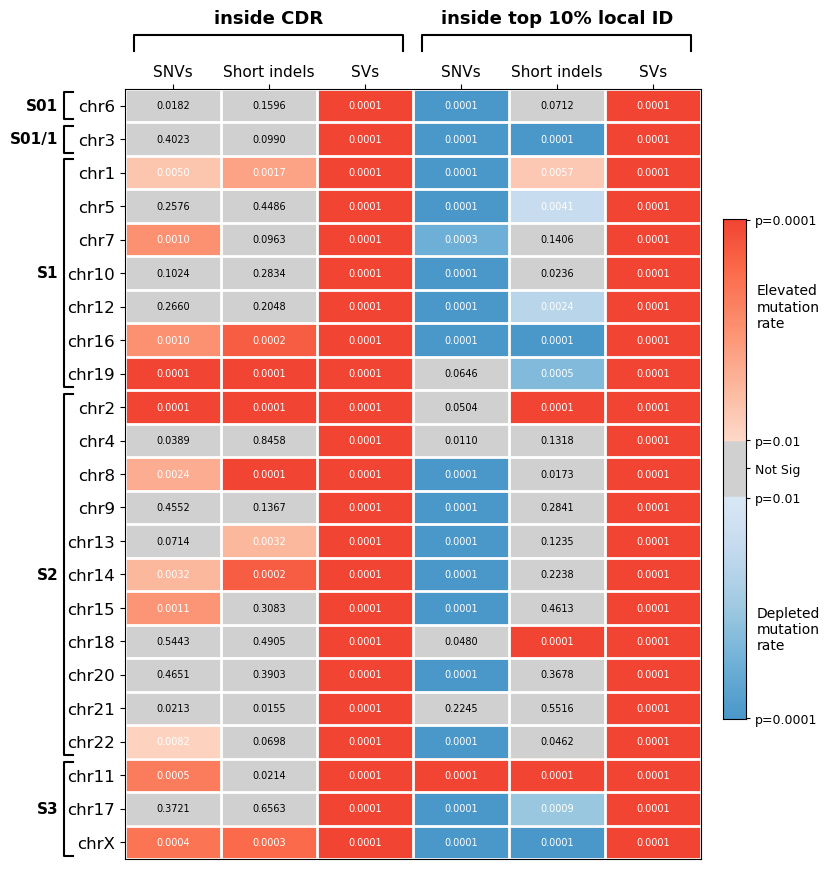

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from matplotlib.transforms import blended_transform_factory

# --- File paths ---
results_files = {
    "CDR\nSNVs": "/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_SNVs/cdr_per_chrom_results.csv",
    "CDR\nShort indels": "/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_short_indels/cdr_indel_per_chrom_results.csv",
    "CDR\nSVs": "/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_results_10k_reps_svs/local_id_sv_per_chrom_results.csv",
    "top 10% \n Local ID\nSNVs": "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps/local_id_per_chrom_results.csv",
    "top 10% \nLocal ID\nShort indels": "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_short_indels/local_id_indel_per_chrom_results.csv",
    "top 10% \nLocal ID\nSVs": "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_svs/local_id_sv_per_chrom_results.csv",
}

# --- Load SF labels ---
sf_df = pd.read_csv("/private/groups/patenlab/mira/centrolign/annotations/chm13/chm13_chrom_SF_labels.txt",
                     header=None, names=["chr", "SF_label"])
sf_df = sf_df.dropna(subset=["chr"])
sf_map = dict(zip(sf_df["chr"], sf_df["SF_label"]))

# Define SF label display order
sf_order = [ "S01",  "S01/1", "S1","S2", "S3"]

# --- Load data ---
p_thresh = 0.01
pval_dfs = {}
direction_dfs = {}
for label, path in results_files.items():
    df = pd.read_csv(path).set_index("chr")
    pval_dfs[label] = df["p_value"]
    direction_dfs[label] = np.sign(df["test_stat"])

pval_df = pd.DataFrame(pval_dfs)
direction_df = pd.DataFrame(direction_dfs)

# Remove chrY
pval_df = pval_df[~pval_df.index.str.contains("chrY")]
direction_df = direction_df[~direction_df.index.str.contains("chrY")]

# Sort by SF label, then by chromosome number within each SF group
def chr_num(c):
    num = c.replace("chr", "")
    return int(num) if num.isdigit() else 99

def sf_sort_key(c):
    sf = sf_map.get(c, "ZZZ")
    sf_rank = sf_order.index(sf) if sf in sf_order else len(sf_order)
    return (sf_rank, chr_num(c))

sorted_chroms = sorted(pval_df.index, key=sf_sort_key)
pval_df = pval_df.reindex(sorted_chroms)
direction_df = direction_df.reindex(sorted_chroms)

# --- Build RGBA image ---
min_p = 0.0001
log_min = np.log10(min_p)
log_max = np.log10(p_thresh)

red_cmap = plt.cm.Reds
blue_cmap = plt.cm.Blues
grey_color = np.array([0.816, 0.816, 0.816, 1.0])

int_lo, int_hi = 0.15, 0.6

rgba_image = np.zeros((len(pval_df), len(pval_df.columns), 4))

for i, chrom in enumerate(pval_df.index):
    for j, col in enumerate(pval_df.columns):
        p = pval_df.loc[chrom, col]
        d = direction_df.loc[chrom, col]

        if p >= p_thresh or np.isnan(p):
            rgba_image[i, j] = grey_color
        else:
            log_p = np.log10(max(p, min_p))
            intensity = int_lo + (int_hi - int_lo) * (log_max - log_p) / (log_max - log_min)
            intensity = np.clip(intensity, int_lo, int_hi)

            if d > 0:
                rgba_image[i, j] = red_cmap(intensity)
            else:
                rgba_image[i, j] = blue_cmap(intensity)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 10))
ax.imshow(rgba_image, aspect="auto")

# Grid lines
for i in range(pval_df.shape[0] + 1):
    ax.axhline(i - 0.5, color="white", linewidth=2)
for j in range(pval_df.shape[1] + 1):
    ax.axvline(j - 0.5, color="white", linewidth=2)

# Labels
ax.set_xticks(range(len(pval_df.columns)))
display_labels = ["SNVs", "Short indels", "SVs", "SNVs", "Short indels", "SVs"]
ax.set_xticklabels(display_labels, fontsize=11, ha="center")
ax.set_yticks(range(len(pval_df.index)))
ax.set_yticklabels(pval_df.index, fontsize=12)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Annotate with p-values
for i, chrom in enumerate(pval_df.index):
    for j, col in enumerate(pval_df.columns):
        p = pval_df.loc[chrom, col]
        if np.isnan(p):
            continue
        text = f"{p:.4f}"
        text_color = "white" if p < p_thresh else "black"
        ax.text(j, i, text, ha="center", va="center", fontsize=7, color=text_color)

# --- Combined gradient legend ---
n_grad = 128
blue_colors = [blue_cmap(int_lo + (int_hi - int_lo) * i / (n_grad - 1)) for i in range(n_grad)]
blue_colors = blue_colors[::-1]
red_colors = [red_cmap(int_lo + (int_hi - int_lo) * i / (n_grad - 1)) for i in range(n_grad)]

n_grey = 32
grey_band = [grey_color.tolist()] * n_grey

combined_colors = blue_colors + grey_band + red_colors
combined_cmap = mcolors.ListedColormap(combined_colors)

cax = fig.add_axes([0.845, 0.25, 0.025, 0.5])
gradient = np.linspace(0, 1, len(combined_colors)).reshape(-1, 1)
cax.imshow(gradient, aspect="auto", cmap=combined_cmap, origin="lower")
cax.set_xticks([])

n_total = len(combined_colors)
cax.yaxis.tick_right()
cax.set_yticks([0, n_grad - 1, n_total / 2, n_grad + n_grey, n_total - 1])
cax.set_yticklabels([f"p={min_p}", f"p={p_thresh}", "Not Sig", f"p={p_thresh}", f"p={min_p}"],
                     fontsize=9)
cax.tick_params(length=3)

cax.text(1.5, n_grad * 0.4, "Depleted\nmutation\nrate", transform=cax.get_yaxis_transform(),
         fontsize=10, va="center", ha="left")
cax.text(1.5, n_grad + n_grey + n_grad * 0.6, "Elevated\nmutation\nrate", transform=cax.get_yaxis_transform(),
         fontsize=10, va="center", ha="left")

plt.subplots_adjust(right=0.82, left=0.18)

# --- Column brackets (top) ---
trans_col = blended_transform_factory(ax.transData, ax.transAxes)

y_brace = 1.05
brace_h = 0.02
ax.plot([-0.4, -0.4, 2.4, 2.4], [y_brace, y_brace + brace_h, y_brace + brace_h, y_brace],
        color='black', lw=1.5, transform=trans_col, clip_on=False)
ax.text(1, y_brace + brace_h + 0.01, "inside CDR", transform=trans_col,
        ha="center", va="bottom", fontsize=13, fontweight="bold")

ax.plot([2.6, 2.6, 5.4, 5.4], [y_brace, y_brace + brace_h, y_brace + brace_h, y_brace],
        color='black', lw=1.5, transform=trans_col, clip_on=False)
ax.text(4, y_brace + brace_h + 0.01, "inside top 10% local ID", transform=trans_col,
        ha="center", va="bottom", fontsize=13, fontweight="bold")

# --- Row brackets (left, by SF label) ---
trans_row = blended_transform_factory(ax.transAxes, ax.transData)

# Build SF groups from the sorted row order
from collections import OrderedDict
sf_groups = OrderedDict()
for i, chrom in enumerate(pval_df.index):
    sf = sf_map.get(chrom, "?")
    sf_groups.setdefault(sf, []).append(i)

x_brace = -0.09
brace_w = 0.015
for sf_label, row_indices in sf_groups.items():
    y_start = min(row_indices) - 0.4
    y_end = max(row_indices) + 0.4
    ax.plot([x_brace, x_brace - brace_w, x_brace - brace_w, x_brace],
            [y_start, y_start, y_end, y_end],
            color='black', lw=1.5, transform=trans_row, clip_on=False)
    ax.text(x_brace - brace_w - 0.01, (y_start + y_end) / 2, sf_label,
            transform=trans_row, ha="right", va="center", fontsize=11, fontweight="bold")

plt.show()
